In [108]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt


In [100]:
from pathlib import Path

BASE_DIR = Path.cwd()             
RAW_DIR = BASE_DIR / "raw"
PROCESSED_DIR = BASE_DIR / "processed"
REPORTS_DIR = BASE_DIR / "reports" / "figures"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print("CWD:", BASE_DIR)
print("RAW exists:", RAW_DIR.exists())
print("Files in RAW:", [p.name for p in RAW_DIR.glob("*")])

CWD: c:\Users\kiara\OneDrive\Documents\505
RAW exists: True
Files in RAW: ['salesdaily.csv', 'saleshourly.csv', 'salesmonthly.csv', 'salesweekly.csv']


In [101]:
def smart_read(raw_dir: Path, basename: str) -> pd.DataFrame:
    for ext in (".csv", ".CSV", ".xlsx", ".xls"):
        fp = raw_dir / f"{basename}{ext}"
        if fp.exists():
            return pd.read_csv(fp) if ext.lower()==".csv" else pd.read_excel(fp)
    raise FileNotFoundError(f"{basename} not found as .csv/.xlsx/.xls in {raw_dir}")

def coerce_datum(df: pd.DataFrame, df_name: str) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    if "datum" in df.columns:
        df["datum"] = pd.to_datetime(df["datum"], errors="coerce"); return df
    cands = ["date","Date","datetime","Datetime","timestamp","Timestamp"]
    cands += [c for c in df.columns if ("date" in c.lower() or "time" in c.lower())]
    for c in cands:
        if c in df.columns:
            df = df.rename(columns={c:"datum"})
            df["datum"] = pd.to_datetime(df["datum"], errors="coerce")
            return df
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index().rename(columns={"index":"datum"})
        df["datum"] = pd.to_datetime(df["datum"], errors="coerce")
        return df
    raise KeyError(f"[{df_name}] no date column. Columns: {list(df.columns)}")

# Load
daily   = smart_read(RAW_DIR, "salesdaily")
hourly  = smart_read(RAW_DIR, "saleshourly")
weekly  = smart_read(RAW_DIR, "salesweekly")
monthly = smart_read(RAW_DIR, "salesmonthly")

# Standardize date column
daily   = coerce_datum(daily,   "daily")
hourly  = coerce_datum(hourly,  "hourly")
weekly  = coerce_datum(weekly,  "weekly")
monthly = coerce_datum(monthly, "monthly")

print("Loaded shapes:", daily.shape, hourly.shape, weekly.shape, monthly.shape)

Loaded shapes: (2106, 13) (50532, 13) (302, 9) (70, 9)


In [102]:
# clean 
for name, df in {"daily":daily,"hourly":hourly,"weekly":weekly,"monthly":monthly}.items():
    df = coerce_datum(df, name)
    df.drop_duplicates(inplace=True)
    df.dropna(subset=["datum"], inplace=True)
    # convert numeric cols
    for col in df.columns:
        if col != "datum":
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)
    # sort
    df.sort_values("datum", inplace=True)
    df.reset_index(drop=True, inplace=True)
    # overwrite cleaned copy
    locals()[name] = df
    print(f"{name}: {df.shape} rows, {df.isnull().sum().sum()} missing values")

# save cleaned 
daily.to_csv(PROCESSED_DIR / "salesdaily_clean.csv", index=False)
hourly.to_csv(PROCESSED_DIR / "saleshourly_clean.csv", index=False)
weekly.to_csv(PROCESSED_DIR / "salesweekly_clean.csv", index=False)
monthly.to_csv(PROCESSED_DIR / "salesmonthly_clean.csv", index=False)

print("cleaned datasets saved in:", PROCESSED_DIR)

daily: (2106, 13) rows, 0 missing values
hourly: (50532, 13) rows, 0 missing values
weekly: (302, 9) rows, 0 missing values
monthly: (70, 9) rows, 0 missing values
cleaned datasets saved in: c:\Users\kiara\OneDrive\Documents\505\processed


Daily summary:
                                datum        M01AB        M01AE        N02BA  \
count                           2106  2106.000000  2106.000000  2106.000000   
mean   2016-11-19 12:00:00.000000256     5.033683     3.895830     3.880441   
min              2014-01-02 00:00:00     0.000000     0.000000     0.000000   
25%              2015-06-12 06:00:00     3.000000     2.340000     2.000000   
50%              2016-11-19 12:00:00     4.990000     3.670000     3.500000   
75%              2018-04-29 18:00:00     6.670000     5.138000     5.200000   
max              2019-10-08 00:00:00    17.340000    14.463000    16.000000   
std                              NaN     2.737579     2.133337     2.384010   

             N02BE         N05B         N05C          R03          R06  \
count  2106.000000  2106.000000  2106.000000  2106.000000  2106.000000   
mean     29.917095     8.853627     0.593522     5.512262     2.900198   
min       0.000000     0.000000     0.000000     0

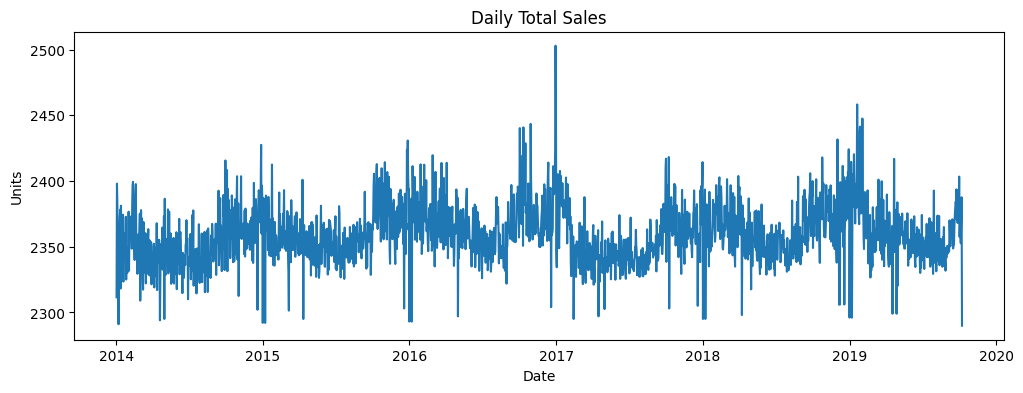

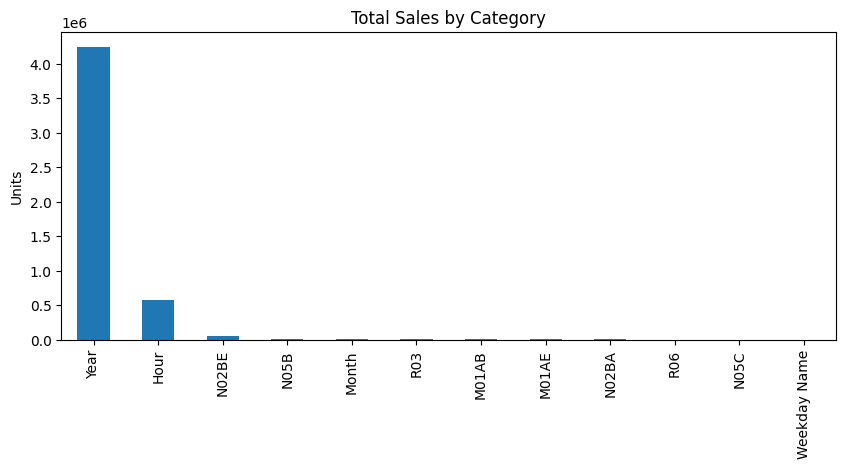

In [103]:
import matplotlib.pyplot as plt

# summary stats
print("Daily summary:\n", daily.describe(include="all"))
print("\nHourly summary:\n", hourly.describe(include="all"))
print("\nWeekly summary:\n", weekly.describe(include="all"))
print("\nMonthly summary:\n", monthly.describe(include="all"))

# total sales columns (sum across categories)
daily["total_sales"] = daily.drop(columns=["datum"]).sum(axis=1)
hourly["total_sales"] = hourly.drop(columns=["datum"]).sum(axis=1)
weekly["total_sales"] = weekly.drop(columns=["datum"]).sum(axis=1)
monthly["total_sales"] = monthly.drop(columns=["datum"]).sum(axis=1)

# daily trend
plt.figure(figsize=(12,4))
plt.plot(daily["datum"], daily["total_sales"])
plt.title("Daily Total Sales")
plt.xlabel("Date"); plt.ylabel("Units")
plt.show()

# category totals
totals = daily.drop(columns=["datum","total_sales"]).sum().sort_values(ascending=False)
totals.plot(kind="bar", figsize=(10,4), title="Total Sales by Category")
plt.ylabel("Units")
plt.show()


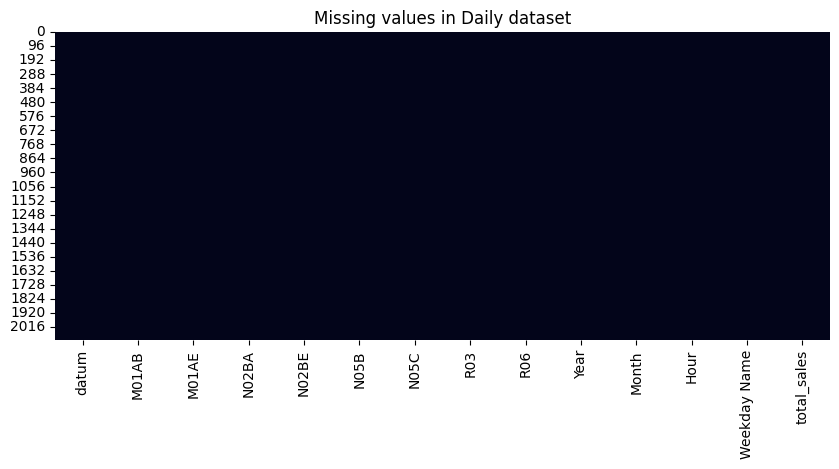

In [109]:
import seaborn as sns

plt.figure(figsize=(10,4))
sns.heatmap(daily.isnull(), cbar=False)
plt.title("Missing values in Daily dataset")
plt.show()


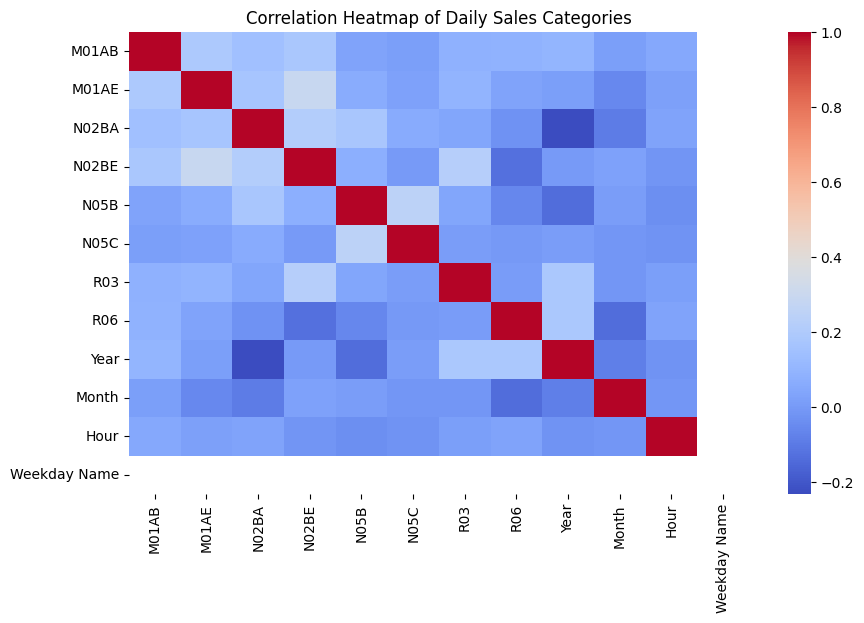

In [110]:
plt.figure(figsize=(10,6))
corr = daily.drop(columns=["datum","total_sales"]).corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Daily Sales Categories")
plt.show()

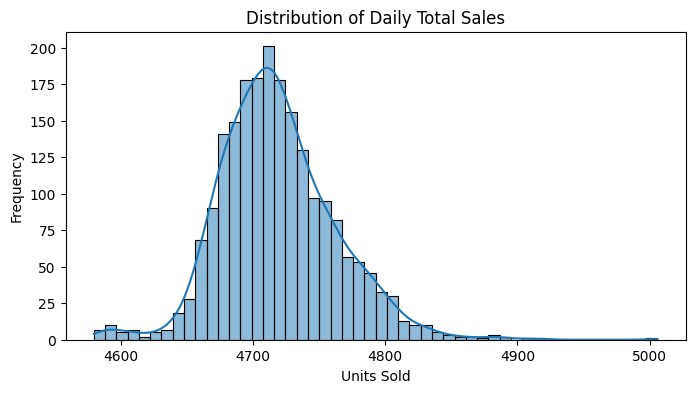

In [111]:
plt.figure(figsize=(8,4))
sns.histplot(daily["total_sales"], bins=50, kde=True)
plt.title("Distribution of Daily Total Sales")
plt.xlabel("Units Sold"); plt.ylabel("Frequency")
plt.show()

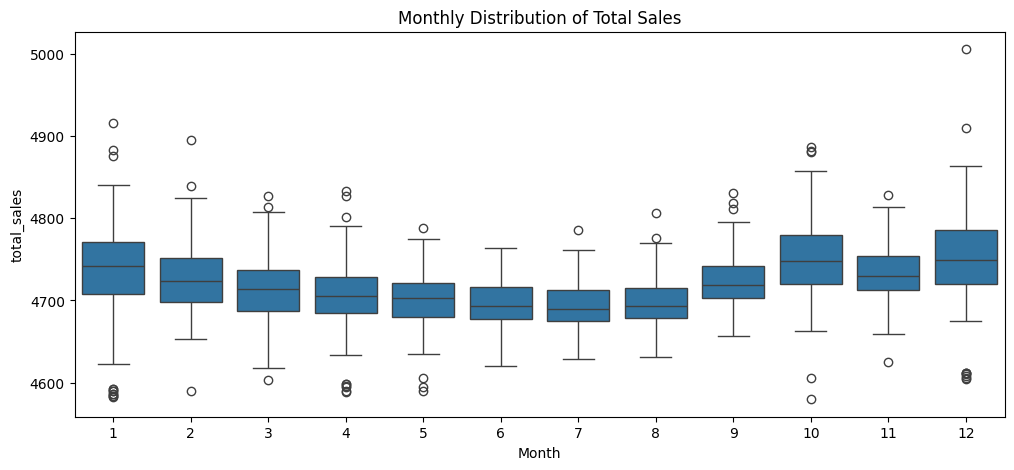

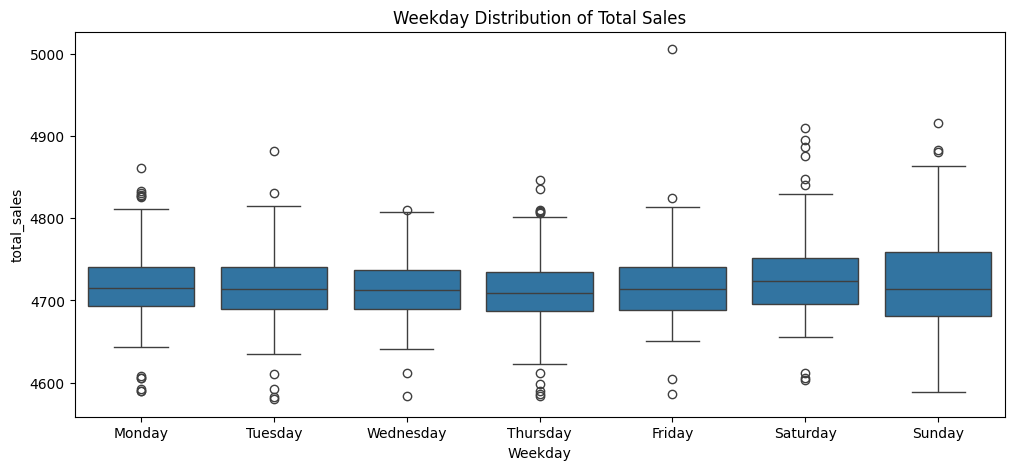

In [112]:
daily["Month"] = daily["datum"].dt.month
daily["Weekday"] = daily["datum"].dt.day_name()

plt.figure(figsize=(12,5))
sns.boxplot(x="Month", y="total_sales", data=daily)
plt.title("Monthly Distribution of Total Sales")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x="Weekday", y="total_sales", data=daily,
            order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Weekday Distribution of Total Sales")
plt.show()


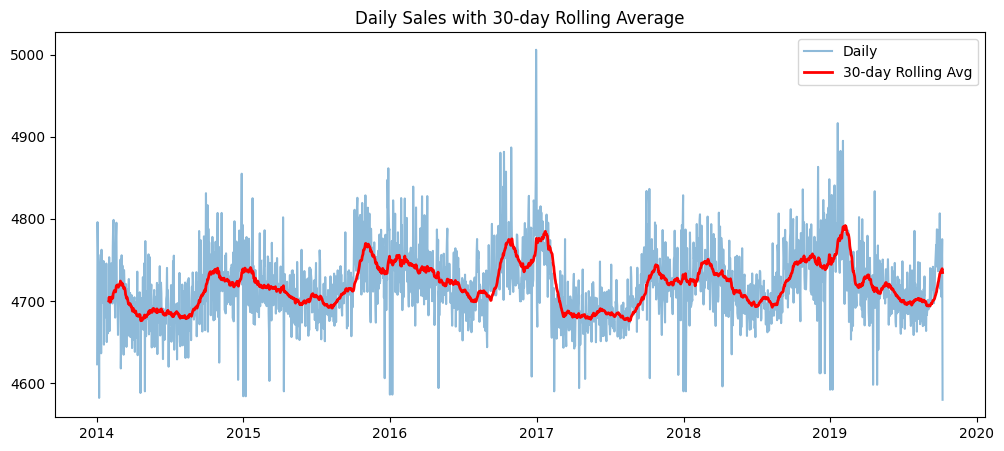

In [113]:
daily["rolling_30d"] = daily["total_sales"].rolling(30).mean()

plt.figure(figsize=(12,5))
plt.plot(daily["datum"], daily["total_sales"], alpha=0.5, label="Daily")
plt.plot(daily["datum"], daily["rolling_30d"], color="red", linewidth=2, label="30-day Rolling Avg")
plt.title("Daily Sales with 30-day Rolling Average")
plt.legend()
plt.show()


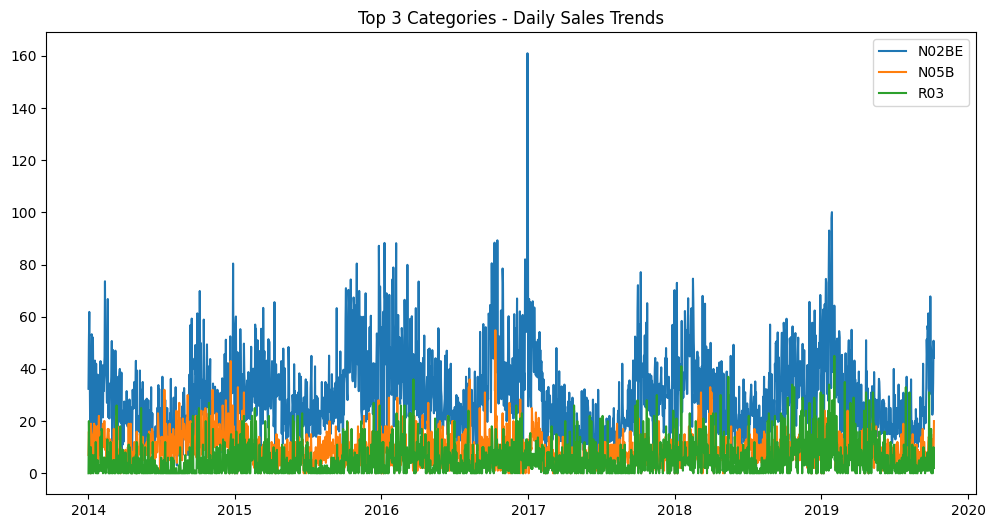

Top 3 categories: ['N02BE', 'N05B', 'R03']


In [121]:
# exclude non-sales columns
exclude_cols = {
    "datum", "total_sales", "rolling_30d",
    "Year", "Month", "Weekday", "Hour", "Week", "Month_num", "Weekday Name"
}
category_cols = [c for c in daily.columns if c not in exclude_cols]

# recompute totals
totals = daily[category_cols].sum().sort_values(ascending=False)

# get top 3 categories only
top3 = totals.index[:3]

plt.figure(figsize=(12,6))
for col in top3:
    plt.plot(daily["datum"], daily[col], label=col)
plt.title("Top 3 Categories - Daily Sales Trends")
plt.legend()
plt.show()

print("Top 3 categories:", top3.tolist())


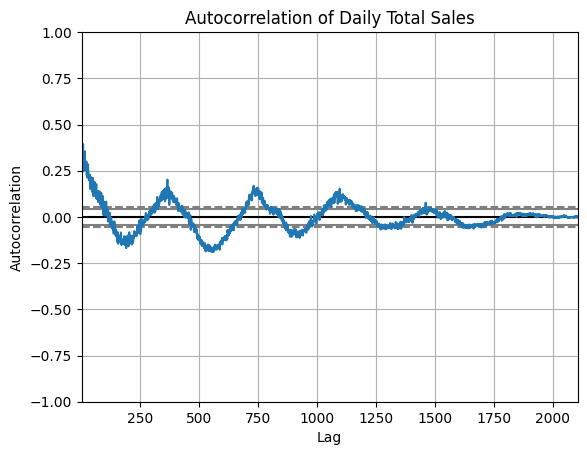

In [117]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(daily["total_sales"])
plt.title("Autocorrelation of Daily Total Sales")
plt.show()


In [118]:
q1, q3 = daily["total_sales"].quantile([0.25,0.75])
iqr = q3 - q1
outliers = daily[(daily["total_sales"] < q1-1.5*iqr) |
                 (daily["total_sales"] > q3+1.5*iqr)]
print(f"Found {len(outliers)} outlier days")


Found 60 outlier days


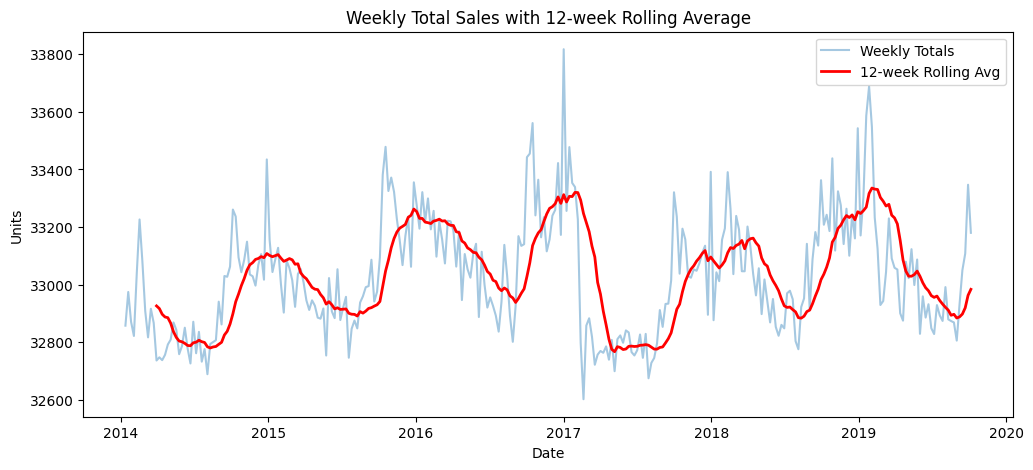

In [125]:
weekly_totals_rolling = weekly_totals.rolling(12).mean()  # ~3-month rolling window

plt.figure(figsize=(12,5))
plt.plot(weekly_totals.index, weekly_totals.values, alpha=0.4, label="Weekly Totals")
plt.plot(weekly_totals_rolling.index, weekly_totals_rolling.values,
         color="red", linewidth=2, label="12-week Rolling Avg")
plt.title("Weekly Total Sales with 12-week Rolling Average")
plt.xlabel("Date"); plt.ylabel("Units")
plt.legend()
plt.show()


C:\Users\kiara\AppData\Local\Temp\ipykernel_26412\2991255627.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  share_monthly = daily_share.resample("M").mean()


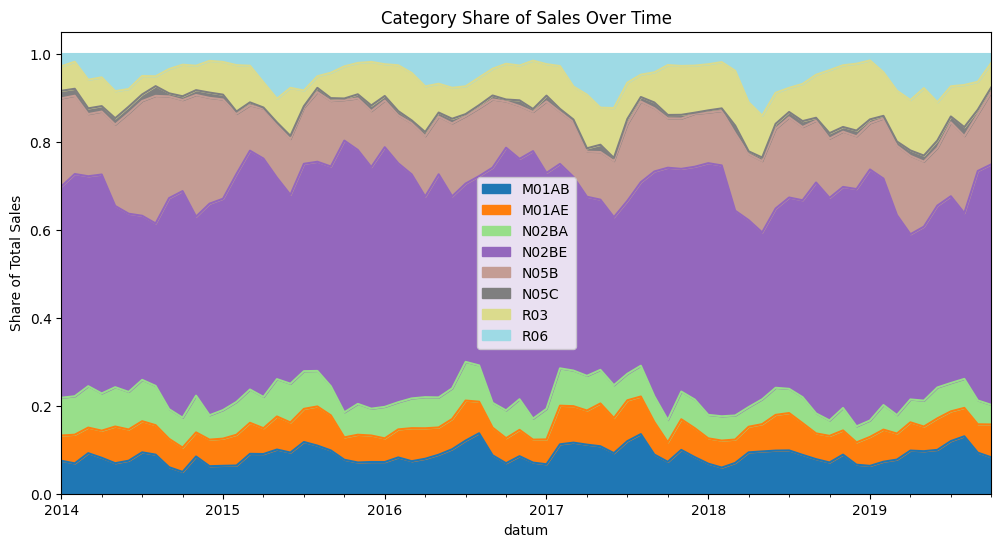

In [123]:
# exclude helper columns
exclude_cols = {
    "datum", "total_sales", "rolling_30d",
    "Year", "Month", "Weekday", "Hour", "Week", "Month_num", "Weekday Name"
}
category_cols = [c for c in daily.columns if c not in exclude_cols]

# normalize to percentages
daily_share = daily.set_index("datum")[category_cols]
daily_share = daily_share.div(daily_share.sum(axis=1), axis=0)

# smooth with monthly averages
share_monthly = daily_share.resample("M").mean()

share_monthly.plot.area(figsize=(12,6), colormap="tab20")
plt.title("Category Share of Sales Over Time")
plt.ylabel("Share of Total Sales")
plt.show()


In [122]:
summary = pd.DataFrame({
    "Total_Sales": daily[category_cols].sum(),
    "Mean_Daily_Sales": daily[category_cols].mean(),
    "Std_Dev": daily[category_cols].std()
}).sort_values("Total_Sales", ascending=False)

print(summary.head(10))


        Total_Sales  Mean_Daily_Sales    Std_Dev
N02BE  63005.402708         29.917095  15.590966
N05B   18645.737500          8.853627   5.605605
R03    11608.822917          5.512262   6.428736
M01AB  10600.937083          5.033683   2.737579
M01AE   8204.618646          3.895830   2.133337
N02BA   8172.209000          3.880441   2.384010
R06     6107.817500          2.900198   2.415816
N05C    1249.958333          0.593522   1.092988
